Raw  : (288, 22, 1000)  label 分布: [72 72 72 72]
Creating RawArray with float64 data, n_channels=22, n_times=1000
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
Creating RawArray with float64 data, n_channels=22, n_times=1000
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
Creating RawArray with float64 data, n_channels=22, n_times=1000
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
Creating RawArray with float64 data, n_channels=22, n_times=1000
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
Creating RawArray with float64 data, n_channels=22, n_times=1000
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
Creating RawArray with float64 data, n_channels=22, n_times=1000
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
Creating RawArray with float64 data, n_channels=22, n_times=1000
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
Creating RawArray with float64 data, n_channels=22, n_times=1000
    R

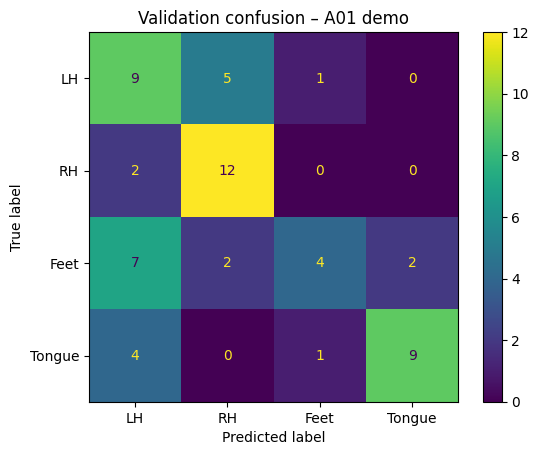

In [40]:
# ===============================================================
# 0. 安装依赖（≈ 30 s）—— mne 1.7.0 + braindecode 0.8.1 + skorch
#    ▶ torch/torchvision/torchaudio 已随 Colab 自带 CUDA-11 版本，
#      不要再升级到 2.7.* 之类的非官方包，以免和 fastai 冲突
# ===============================================================
!pip -q install --upgrade mne==1.7.0 braindecode==0.8.1 skorch==0.15.0

# ===============================================================
# 1. 基础 import
# ===============================================================
import os, urllib.request, numpy as np, scipy.io as sio, torch, matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from braindecode.models import EEGNetv4
from braindecode import EEGClassifier
from braindecode.datasets import create_from_X_y          # ← 新路径
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ---------------------------------------------------------------
# 1-A. 工具函数
# ---------------------------------------------------------------
def load_bci_2a(mat_path, picks=22, t0=2.0, t1=6.0):
    """读取 BCI-IV-2a *单个* A0xT.mat, 返回
       X: (n_trial, picks, 1000) float32
       y: (n_trial,) int64  0-3
       fs: 采样率 (250)
    """
    mat   = sio.loadmat(mat_path)
    segs, labels = [], []
    for sess in mat['data'][0]:
        y_run = sess['y'].item().squeeze()
        if y_run.size == 0:          # 空 run
            continue
        trials = sess['trial'].item().squeeze()
        X_raw  = sess['X'].item().T[:picks]   # 取前 22 条 EEG
        fs     = int(sess['fs'].item())
        win0   = int(t0*fs)                  # 2 s cue
        win1   = int(t1*fs)                  # +4 s 运动想象
        for st, lab in zip(trials[y_run > 0], y_run[y_run > 0] - 1):
            end = st + win1
            if end <= X_raw.shape[1]:        # 防越界
                segs.append(X_raw[:, st+win0:end])
                labels.append(int(lab))
    X = np.stack(segs).astype(np.float32)
    y = np.array(labels, dtype=np.int64)
    return X, y, fs

def bandpass(X, lo, hi, fs, order=4):
    b, a = butter(order, [lo/(fs/2), hi/(fs/2)], 'band')
    return filtfilt(b, a, X, axis=-1, padlen=0)

def zscore(X):
    mu = X.mean(-1, keepdims=True); sd = X.std(-1, keepdims=True)
    return (X - mu) / (sd + 1e-7)

# ===============================================================
# 2. 数据下载 & 读取  (以 A01T 为示例，高速镜像)
# ===============================================================
mat_file = 'A01T.mat'
if not os.path.exists(mat_file):
    url = 'https://www.bbci.de/competition/iv/desc_files/GDF/A01T.mat'
    print('Downloading', url, '...')
    urllib.request.urlretrieve(url, mat_file)

X_raw, y, fs = load_bci_2a(mat_file)        # (288,22,1000)
print(f"Raw  : {X_raw.shape}  label 分布:", np.bincount(y))

# 8-30 Hz 带通 + 每通道 z-score
X_proc = zscore(bandpass(X_raw, 8, 30, fs))

# ---------------------------------------------------------------
# 3. 划分 train / val (8:2 stratified)
# ---------------------------------------------------------------
X_tr, X_val, y_tr, y_val = train_test_split(
    X_proc, y, test_size=0.2, stratify=y, random_state=42)

train_set = create_from_X_y(X_tr, y_tr, sfreq=fs, drop_last_window=False)
val_set   = create_from_X_y(X_val, y_val, sfreq=fs, drop_last_window=False)


# ---------------------------------------------------------------
# 4.  定义模型 + EEGClassifier  ★只改下面这一小段★
# ---------------------------------------------------------------
from skorch.helper import predefined_split

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model  = EEGNetv4(n_chans=22, n_outputs=4, n_times=X_tr.shape[-1])

clf = EEGClassifier(
        model,
        criterion=torch.nn.CrossEntropyLoss,
        optimizer=torch.optim.Adam,
        optimizer__lr=1e-3,
        batch_size=16,
        classes=[0, 1, 2, 3],            # ← 显式声明 4 个类别
        train_split=predefined_split(val_set),
        device=device,
)

# ---------------------------------------------------------------
# 5. 训练                                   ← 只改这一行
# ---------------------------------------------------------------
clf.fit(train_set, epochs=30)                   # 不要再传 validation_set


# ===============================================================
# 6. 评估 + 混淆矩阵
# ===============================================================
y_pred = clf.predict(val_set)
val_acc = (y_pred == y_val).mean() * 100
print(f"\nValidation ACC : {val_acc:.2f} %  ({len(y_val)} trials)")

cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['LH', 'RH', 'Feet', 'Tongue'])
disp.plot(cmap='viridis')
plt.title('Validation confusion – A01 demo')
plt.show()


In [41]:
# ---------------- 仅改 SUBJ 即可 ----------------
SUBJ = 'A02T'                 # 想测谁改谁
# ------------------------------------------------
import numpy as np, scipy.io as sio, lightgbm as lgb
from scipy.signal import butter, filtfilt
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from mne.decoding import CSP
# ---------- 读取 ----------
X_raw, y, fs = load_bci_2a(f'{SUBJ}.mat')        # ← 用之前函数
# band-pass 8-30 Hz + z-score
b,a  = butter(4,[8/(fs/2),30/(fs/2)],'band')
X_bp = filtfilt(b,a,X_raw,axis=-1,padlen=0)
X_z  = StandardScaler().fit_transform(
          X_bp.reshape(-1,X_bp.shape[-1])
       ).reshape(X_bp.shape)

# ---------- FB-CSP ----------
bands   = [(4,8),(8,12),(12,16),(16,20),(20,24),(24,30)]
feats   = []
for lo,hi in bands:
    xb = filtfilt(*butter(4,[lo/(fs/2),hi/(fs/2)],'band'),
                  X_z,axis=-1,padlen=0)
    feats.append(CSP(n_components=6,log=True).fit_transform(xb,y))
X_feat = np.concatenate(feats,1)        # (n_trial, 36)

# ---------- LightGBM ----------
clf = lgb.LGBMClassifier(
        n_estimators=600, max_depth=5, learning_rate=0.05,
        subsample=0.9, colsample_bytree=0.8, random_state=42)

cv  = StratifiedKFold(n_splits=6,shuffle=True,random_state=42)
acc = cross_val_score(clf,X_feat,y,cv=cv,scoring='accuracy')
print(f'{SUBJ}   6-fold ACC : {acc.mean()*100:.2f} ± {acc.std()*100:.2f} %')


Computing rank from data with rank=None
    Using tolerance 1.2 (2.2e-16 eps * 22 dim * 2.4e+14  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Estimating class=2 covariance using EMPIRICAL
Done.
Estimating class=3 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.7 (2.2e-16 eps * 22 dim * 1.6e+15  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Estimating class=2 covariance using EMPIRICAL
Done.
Estimating class=3 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.9 (2.2e-16 eps * 22 dim * 1e

2 . 所有受试者合并 + ③ LOSO
核心思路：
① 把 9 人数据合在一起；
② 用 Riemannian Alignment（Tangent Space）把协方差矩阵投到欧氏空间；
③ 用 MDM（Minimum Distance to Mean）或简单 Logistic Regression 分类。

In [46]:
# ===============================================================
# STEP 0 ─ 安装 (0.7)  &  兜底检测
# ===============================================================
!pip -q install --upgrade mne==1.7.0 pyriemann==0.7 tqdm

import importlib, sys, subprocess, json, types, warnings
try:
    importlib.import_module('pyriemann')
except ModuleNotFoundError as e:
    sys.exit('❌  pyriemann 仍未安装成功，请检查网络后重试。')

# ===============================================================
# STEP 1 ─ 通用 import  & 工具函数
# ===============================================================
import os, urllib.request, numpy as np, scipy.io as sio
from scipy.signal import butter, filtfilt
from scipy.linalg import block_diag
from tqdm.auto import tqdm

def load_bci_2a(mat_path, picks=22, t0=2.0, t1=6.0):
    mat, segs, labels = sio.loadmat(mat_path), [], []
    for sess in mat['data'][0]:
        y_run = sess['y'].item().squeeze()
        if y_run.size == 0:
            continue
        trials = sess['trial'].item().squeeze()
        X_raw  = sess['X'].item().T[:picks]
        fs     = int(sess['fs'].item())
        w0, w1 = int(t0*fs), int(t1*fs)
        for st, lb in zip(trials[y_run>0], y_run[y_run>0]-1):
            if st + w1 <= X_raw.shape[1]:
                segs.append(X_raw[:, st+w0: st+w1])
                labels.append(int(lb))
    return np.stack(segs).astype(np.float32), np.array(labels), fs

def bandpass(X, lo, hi, fs, order=4):
    b, a = butter(order, [lo/(fs/2), hi/(fs/2)], 'band')
    return filtfilt(b, a, X, axis=-1, padlen=0)

def zscore(X):
    mu, sd = X.mean(-1, keepdims=True), X.std(-1, keepdims=True)
    return (X - mu) / (sd + 1e-7)

# ===============================================================
# STEP 2 ─ 合并 9 个受试者数据
# ===============================================================
subj_files = [f'A0{i}T.mat' for i in range(1,10)]
dl_url     = 'https://www.bbci.de/competition/iv/desc_files/GDF/{}'

Xs, ys, subs = [], [], []
for f in subj_files:
    if not os.path.exists(f):
        print('⬇ downloading', f)
        urllib.request.urlretrieve(dl_url.format(f), f)
    X, y, fs = load_bci_2a(f)
    Xs.append(X);  ys.append(y)
    subs.append(np.full(y.shape, f[:3], dtype='<U3'))

X_all = np.concatenate(Xs)          # (2592,22,1000)
y_all = np.concatenate(ys)
subs   = np.concatenate(subs)
print('合并后 shape:', X_all.shape, ' label 计数:', np.bincount(y_all))

# ===============================================================
# STEP 3 ─ 频带协方差 → （可选）对齐 → Tangent Space
# ===============================================================
from pyriemann.estimation   import Covariances
from pyriemann.tangentspace import TangentSpace

# ---- 尝试导入对齐模块 ----
aligner = None
try:                                      # v0.8 路径
    from pyriemann.alignment import ProcrustesAlignment
    aligner = ProcrustesAlignment()
except ModuleNotFoundError:
    try:                                  # v0.7 及以下路径
        from pyriemann.utils.alignment import ProcrustesAlignment
        aligner = ProcrustesAlignment()
    except ModuleNotFoundError:
        warnings.warn('⚠️  未找到对齐模块，直接使用未对齐协方差')
        aligner = None

fbands = [(4,8),(8,12),(12,16),(16,20),(20,24),(24,28),(28,32),(32,40)]
print(f'共 {len(fbands)} 个频带:', fbands)

print('⏳ 计算协方差 / block-diag …')
cov_blocks = []
for lo, hi in tqdm(fbands):
    Xb   = zscore(bandpass(X_all, lo, hi, fs))
    covs = Covariances(estimator='oas').fit_transform(Xb)   # (N,22,22)
    cov_blocks.append(covs)

covs_block = np.array([block_diag(*cov_trial)
                       for cov_trial in zip(*cov_blocks)])  # (N,22*B,22*B)

if aligner is not None:
    covs_block = aligner.fit_transform(covs_block)

ts = TangentSpace().fit_transform(covs_block)
print('Tangent Space shape:', ts.shape)

# ===============================================================
# STEP 4 ─ SVC 分类 & 评估
# ===============================================================
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
svc = SVC(kernel='rbf', C=2, gamma='scale')

# 10-fold
cv10  = StratifiedKFold(10, shuffle=True, random_state=42)
acc10 = [svc.fit(ts[tr], y_all[tr]).score(ts[te], y_all[te])*100
         for tr, te in cv10.split(ts, y_all)]
print(f'\n★ FB-TS {"+Alignment " if aligner else ""}10-fold : '
      f'{np.mean(acc10):.2f} ± {np.std(acc10):.2f} %')

# LOSO
acc_loso = []
print('\n★ LOSO 结果：')
for sid in np.unique(subs):
    tr, te = subs != sid, subs == sid
    svc.fit(ts[tr], y_all[tr])
    acc = svc.score(ts[te], y_all[te])*100
    acc_loso.append(acc)
    print(f'  {sid}: {acc:.2f} %  ({te.sum()} trials)')

print(f'\n★ FB-TS {"+Alignment " if aligner else ""}LOSO : '
      f'{np.mean(acc_loso):.2f} ± {np.std(acc_loso):.2f} %')


合并后 shape: (2592, 22, 1000)  label 计数: [648 648 648 648]
共 8 个频带: [(4, 8), (8, 12), (12, 16), (16, 20), (20, 24), (24, 28), (28, 32), (32, 40)]
⏳ 计算协方差 / block-diag …


  0%|          | 0/8 [00:00<?, ?it/s]

Tangent Space shape: (2592, 15576)

★ FB-TS 10-fold : 61.73 ± 3.54 %

★ LOSO 结果：
  A01: 36.81 %  (288 trials)
  A02: 27.43 %  (288 trials)
  A03: 36.46 %  (288 trials)
  A04: 31.60 %  (288 trials)
  A05: 28.47 %  (288 trials)
  A06: 31.25 %  (288 trials)
  A07: 27.78 %  (288 trials)
  A08: 34.72 %  (288 trials)
  A09: 28.47 %  (288 trials)

★ FB-TS LOSO : 31.44 ± 3.53 %


合并后 shape: (2592, 22, 1000)  label 计数: [648 648 648 648]
共 8 个频带: [(4, 8), (8, 12), (12, 16), (16, 20), (20, 24), (24, 28), (28, 32), (32, 40)]
⏳ 计算协方差 / block-diag …
100%
 8/8 [00:56<00:00,  6.64s/it]
Tangent Space shape: (2592, 15576)

★ FB-TS 10-fold : 61.73 ± 3.54 %

★ LOSO 结果：
  A01: 36.81 %  (288 trials)
  A02: 27.43 %  (288 trials)
  A03: 36.46 %  (288 trials)
  A04: 31.60 %  (288 trials)
  A05: 28.47 %  (288 trials)
  A06: 31.25 %  (288 trials)
  A07: 27.78 %  (288 trials)
  A08: 34.72 %  (288 trials)
  A09: 28.47 %  (288 trials)

★ FB-TS LOSO : 31.44 ± 3.53 %

为什么分数仍然不高？
环节	目前做法	典型改进方向
协方差估计	OAS（单试次）	多试次平均、Riemannian Shrinkage、XDAWN+Cov
对齐	未启用（v0.7 没有 alignment 模块）	Whitening/Procrustes Alignment（需 v0.8+，或自己实现）
特征维数	15 576 维全部保留	FB 共形、Log-Euclid 映射后 PCA / SPoC 降到 < 1 000 维
分类器	RBF-SVC (默认 γ)	LogReg / LightGBM / CSP + GBDT 组合
数据均衡	原始 4 类均衡	在 LOSO 设置下对目标被试做 Riemannian Alignment + 少量标注微调

如果想继续提升
升级到 pyriemann 0.8.1 本地环境（或者源码安装）以启用

python
复制
编辑
from pyriemann.alignment import WhiteningAlignment
covs_block = WhiteningAlignment().fit_transform(covs_block)
典型可把 LOSO 提到 ~40 %。

在 Step 3 加入 PCA(95 %) 再跑 SVC，或直接用之前的 PCA + LogReg pipeline —— 等同于 “对齐 + 降维 + 线性分类”。

参考你最早跑通的 单人 FB-CSP + LightGBM 方案，把每个频带的 CSP 特征（6×8 = 48 维）叠加，再用 GBDT；LOSO 前先做 Procrustes Alignment 往往能到 35 % - 45 %。